In [1]:
%config InlineBackend.figure_format = "retina"

In [2]:
import jupyter_black

jupyter_black.load()

In [3]:
from importlib import resources

from jax import grad, jit, vmap
import jax.numpy as jnp
import mols2grid
import numpy as np
import pymbar
from rdkit import Chem
from rdkit.Chem.Draw import IPythonConsole

import timemachine

# Relative hydration free energy

Fontconfig error: Cannot load default config file: No such file: (null)


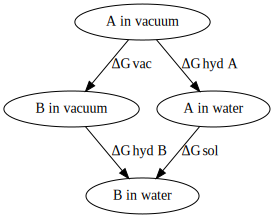

In [4]:
import graphviz

g = graphviz.Digraph()
g.node("A", label="A in vacuum")
g.node("B", label="B in vacuum")
g.node("AW", label="A in water")
g.node("BW", label="B in water")
g.edge("A", "B", label="<ΔG<SUB>vac</SUB>>")
g.edge("AW", "BW", label="<ΔG<SUB>sol</SUB>>")
g.edge("A", "AW", label="<ΔG<SUB>hyd A</SUB>>")
g.edge("B", "BW", label="<ΔG<SUB>hyd B</SUB>>")
g

\begin{equation}
0 = \Delta G_{\text{vac}} - \Delta G_{\text{sol}} - \Delta G_{\text{hyd A}} + \Delta G_{\text{hyd B}}
\end{equation}

\begin{equation}
\Delta \Delta G_{\text{hyd}} = \Delta G_{\text{hyd B}} - \Delta G_{\text{hyd A}} = \Delta G_{\text{sol}} - \Delta G_{\text{vac}}
\end{equation}

## Atom mapping

In [5]:
from timemachine.datasets import fetch_freesolv
from timemachine.fe import atom_mapping
from timemachine.fe.utils import get_mol_name, plot_atom_mapping_grid

In [6]:
mols = {get_mol_name(mol): mol for mol in fetch_freesolv()}

[12:32:16] Warning: molecule is tagged as 3D, but all Z coords are zero


In [7]:
mol_a = mols["mobley_3053621"]
mol_b = mols["mobley_3398536"]

In [8]:
mols2grid.display([mol_a, mol_b])

In [9]:
def compute_atom_mapping(mcs_threshold=2.0):
    mcs_result = atom_mapping.mcs(
        mol_a, mol_b, threshold=mcs_threshold, conformer_aware=False
    )
    query_mol = Chem.MolFromSmarts(mcs_result.smartsString)
    return atom_mapping.get_core_by_mcs(
        mol_a, mol_b, query_mol, threshold=mcs_threshold
    )

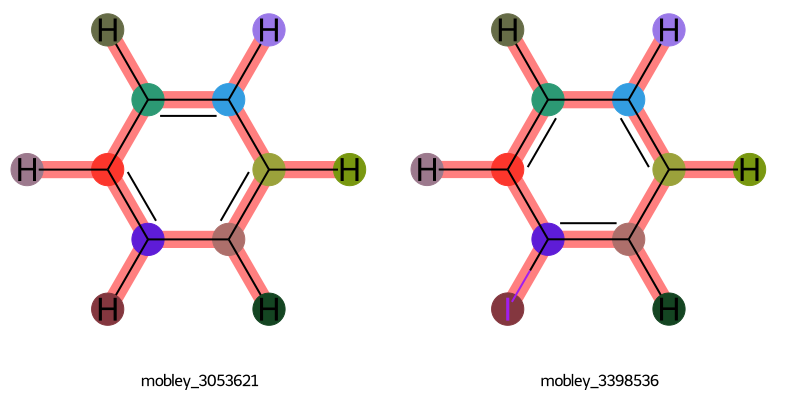

In [10]:
core = compute_atom_mapping()
plot_atom_mapping_grid(mol_a, mol_b, core)

## Vacuum leg

In [11]:
from timemachine.constants import DEFAULT_FF
from timemachine.fe.rbfe import estimate_relative_free_energy
from timemachine.ff import Forcefield

In [12]:
forcefield = Forcefield.load_from_file(DEFAULT_FF)

mobley_3053621_mobley_3398536_vacuum BAR: lambda 2 -> 3 dG: 0.062 +- 0.044 kJ/mol
         Current function value: 174.838886
         Iterations: 48
         Function evaluations: 134
         Gradient evaluations: 123
mobley_3053621_mobley_3398536_vacuum BAR: lambda 3 -> 4 dG: 0.037 +- 0.044 kJ/mol
         Current function value: 174.944507
         Iterations: 46
         Function evaluations: 140
         Gradient evaluations: 128
mobley_3053621_mobley_3398536_vacuum BAR: lambda 4 -> 5 dG: 0.073 +- 0.042 kJ/mol
         Current function value: 175.089965
         Iterations: 53
         Function evaluations: 441
         Gradient evaluations: 418
mobley_3053621_mobley_3398536_vacuum BAR: lambda 5 -> 6 dG: 0.141 +- 0.067 kJ/mol
         Current function value: 175.260569
         Iterations: 45
         Function evaluations: 122
         Gradient evaluations: 114
mobley_3053621_mobley_3398536_vacuum BAR: lambda 6 -> 7 dG: 0.016 +- 0.093 kJ/mol
         Current function value: 175.4

mobley_3053621_mobley_3398536_vacuum BAR: lambda 15 -> 16 dG: -0.295 +- 0.048 kJ/mol
         Current function value: 174.338822
         Iterations: 12
         Function evaluations: 129
         Gradient evaluations: 112
mobley_3053621_mobley_3398536_vacuum BAR: lambda 16 -> 17 dG: -0.166 +- 0.031 kJ/mol
         Current function value: 174.610221
         Iterations: 11
         Function evaluations: 78
         Gradient evaluations: 66
mobley_3053621_mobley_3398536_vacuum BAR: lambda 17 -> 18 dG: -0.141 +- 0.031 kJ/mol
         Current function value: 175.286932
         Iterations: 11
         Function evaluations: 81
         Gradient evaluations: 70
mobley_3053621_mobley_3398536_vacuum BAR: lambda 18 -> 19 dG: -0.172 +- 0.031 kJ/mol
         Current function value: 173.914408
         Iterations: 41
         Function evaluations: 227
         Gradient evaluations: 211
mobley_3053621_mobley_3398536_vacuum BAR: lambda 19 -> 20 dG: -0.096 +- 0.015 kJ/mol
         Current function v

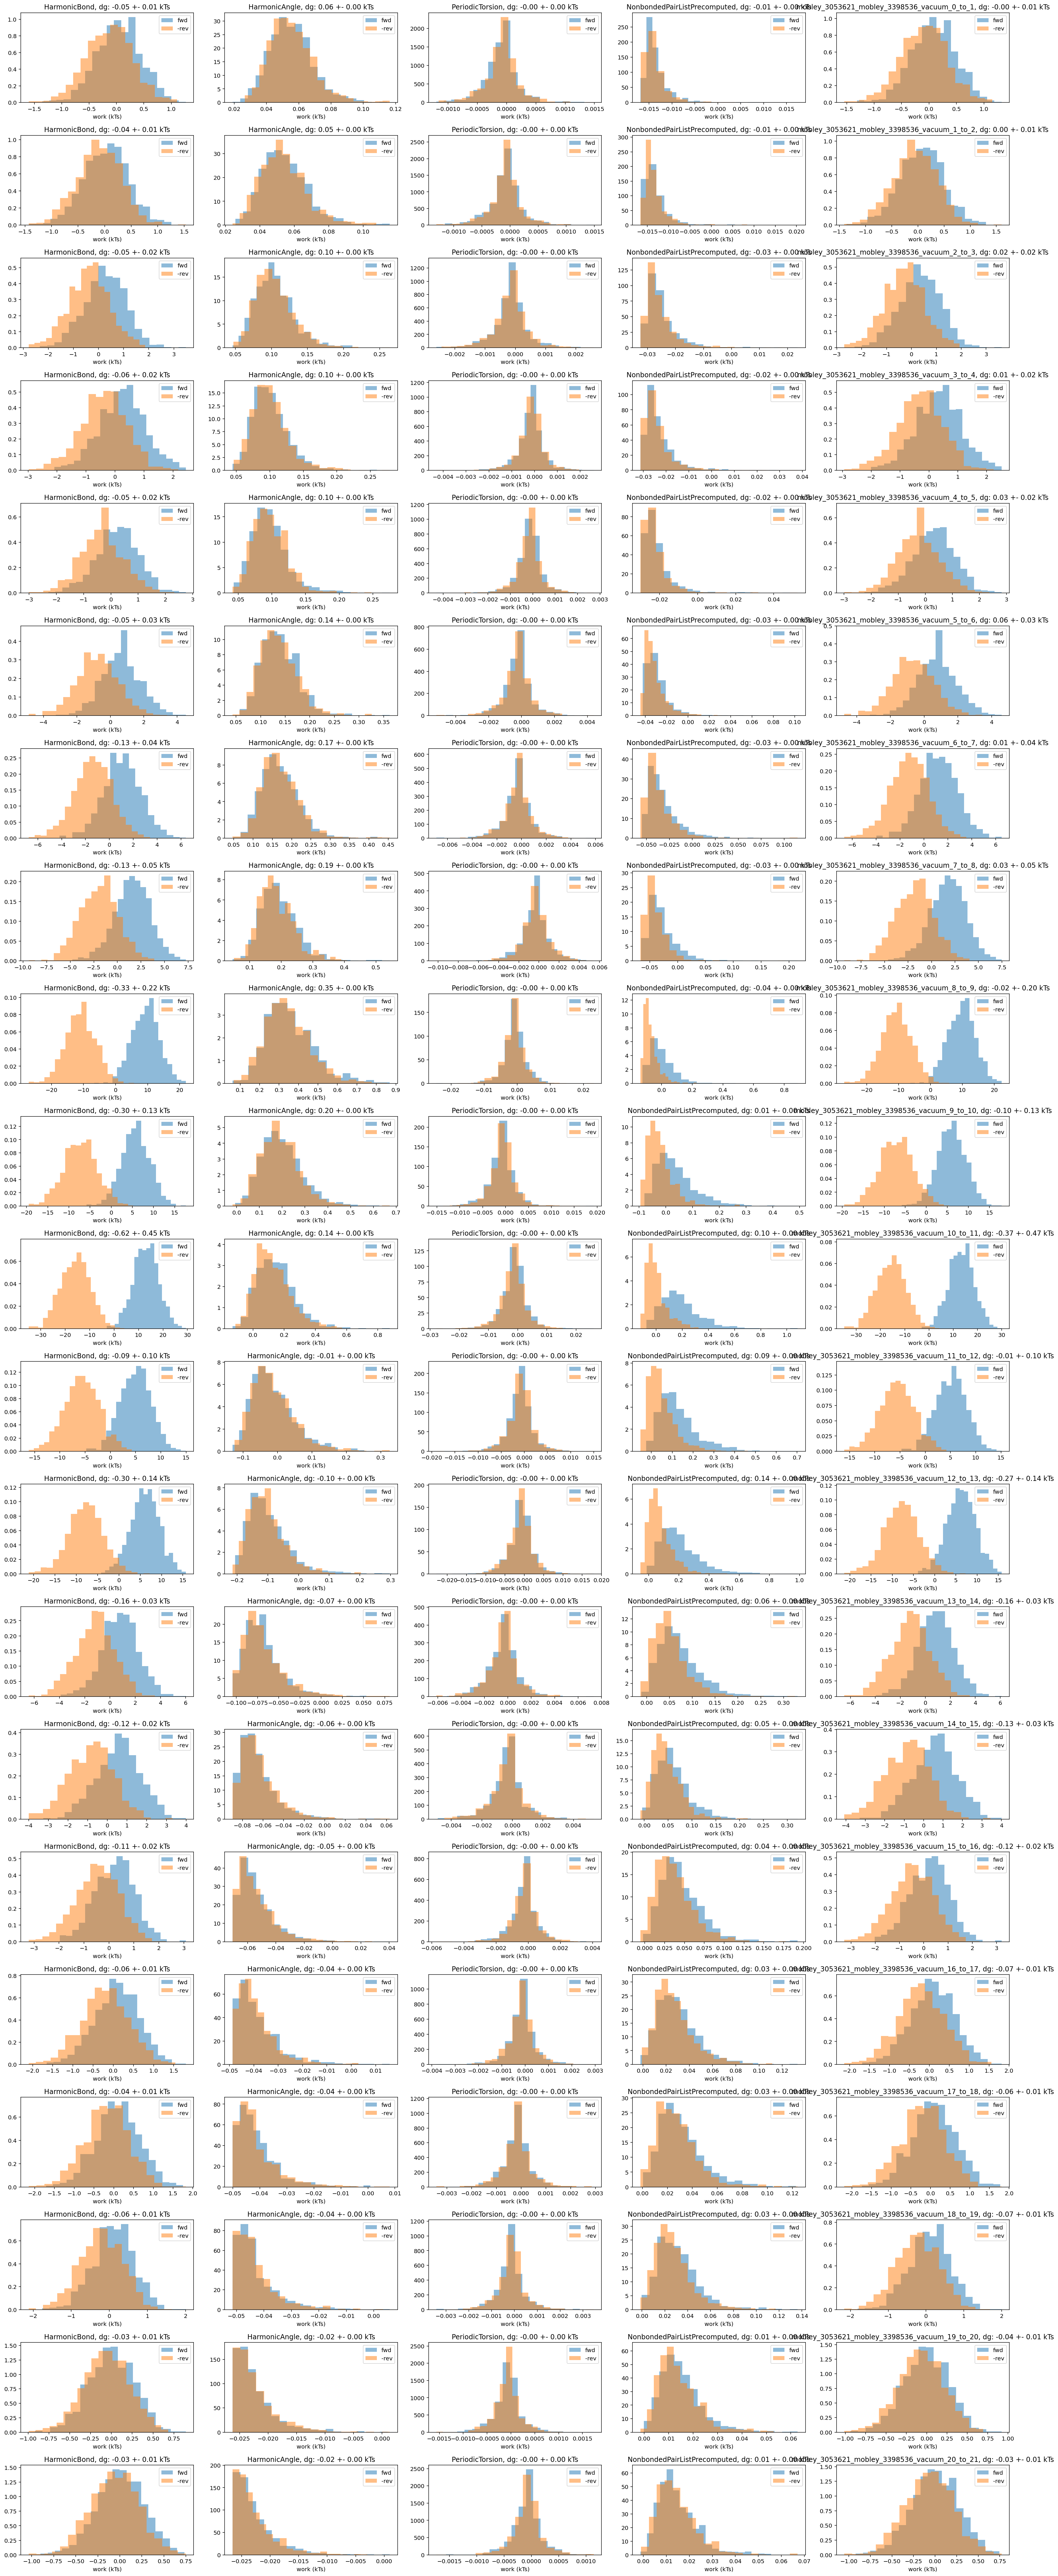

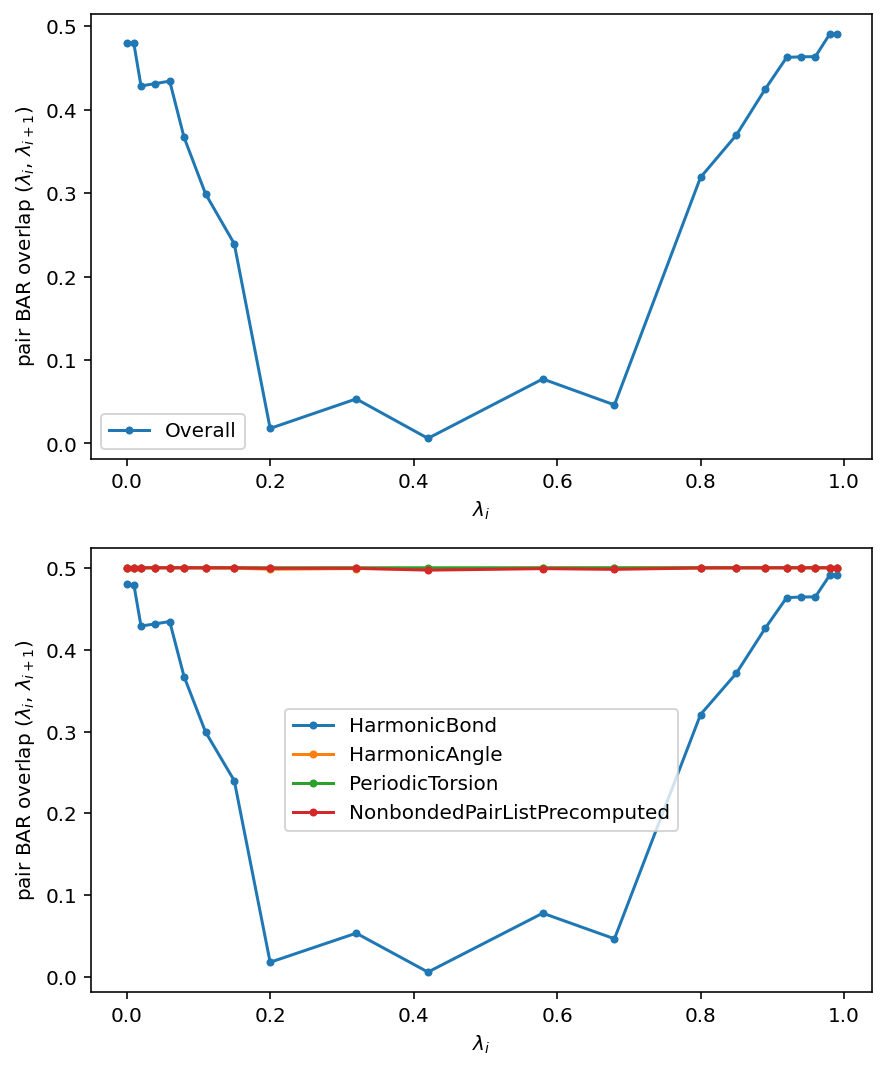

In [13]:
%%time
vacuum_res = estimate_relative_free_energy(
    mol_a,
    mol_b,
    core,
    forcefield,
    host_config=None,
    seed=123,
    n_frames=1000,
    prefix="vacuum",
    n_eq_steps=10000,
)

In [14]:
from timemachine.constants import KCAL_TO_KJ

In [15]:
vacuum_dG = np.array(vacuum_res.all_dGs).sum() / KCAL_TO_KJ
vacuum_dG_err = np.linalg.norm(vacuum_res.all_errs) / KCAL_TO_KJ
vacuum_dG, vacuum_dG_err

(-0.771034472021442, 0.3332610293886064)

## Solvent leg

In [16]:
from timemachine.fe.rbfe import HostConfig
from timemachine.md.builders import build_water_system

         Current function value: -104254.241733
         Iterations: 52
         Function evaluations: 136
         Gradient evaluations: 128
         Current function value: -104247.873842
         Iterations: 40
         Function evaluations: 179
         Gradient evaluations: 170
mobley_3053621_mobley_3398536_solvent BAR: lambda 0 -> 1 dG: 0.116 +- 0.022 kJ/mol
         Current function value: -104249.824572
         Iterations: 41
         Function evaluations: 119
         Gradient evaluations: 114
mobley_3053621_mobley_3398536_solvent BAR: lambda 1 -> 2 dG: 0.093 +- 0.023 kJ/mol
         Current function value: -104256.525310
         Iterations: 54
         Function evaluations: 121
         Gradient evaluations: 111
mobley_3053621_mobley_3398536_solvent BAR: lambda 2 -> 3 dG: 0.236 +- 0.046 kJ/mol
         Current function value: -104257.770278
         Iterations: 65
         Function evaluations: 139
         Gradient evaluations: 134
mobley_3053621_mobley_3398536_solvent BAR

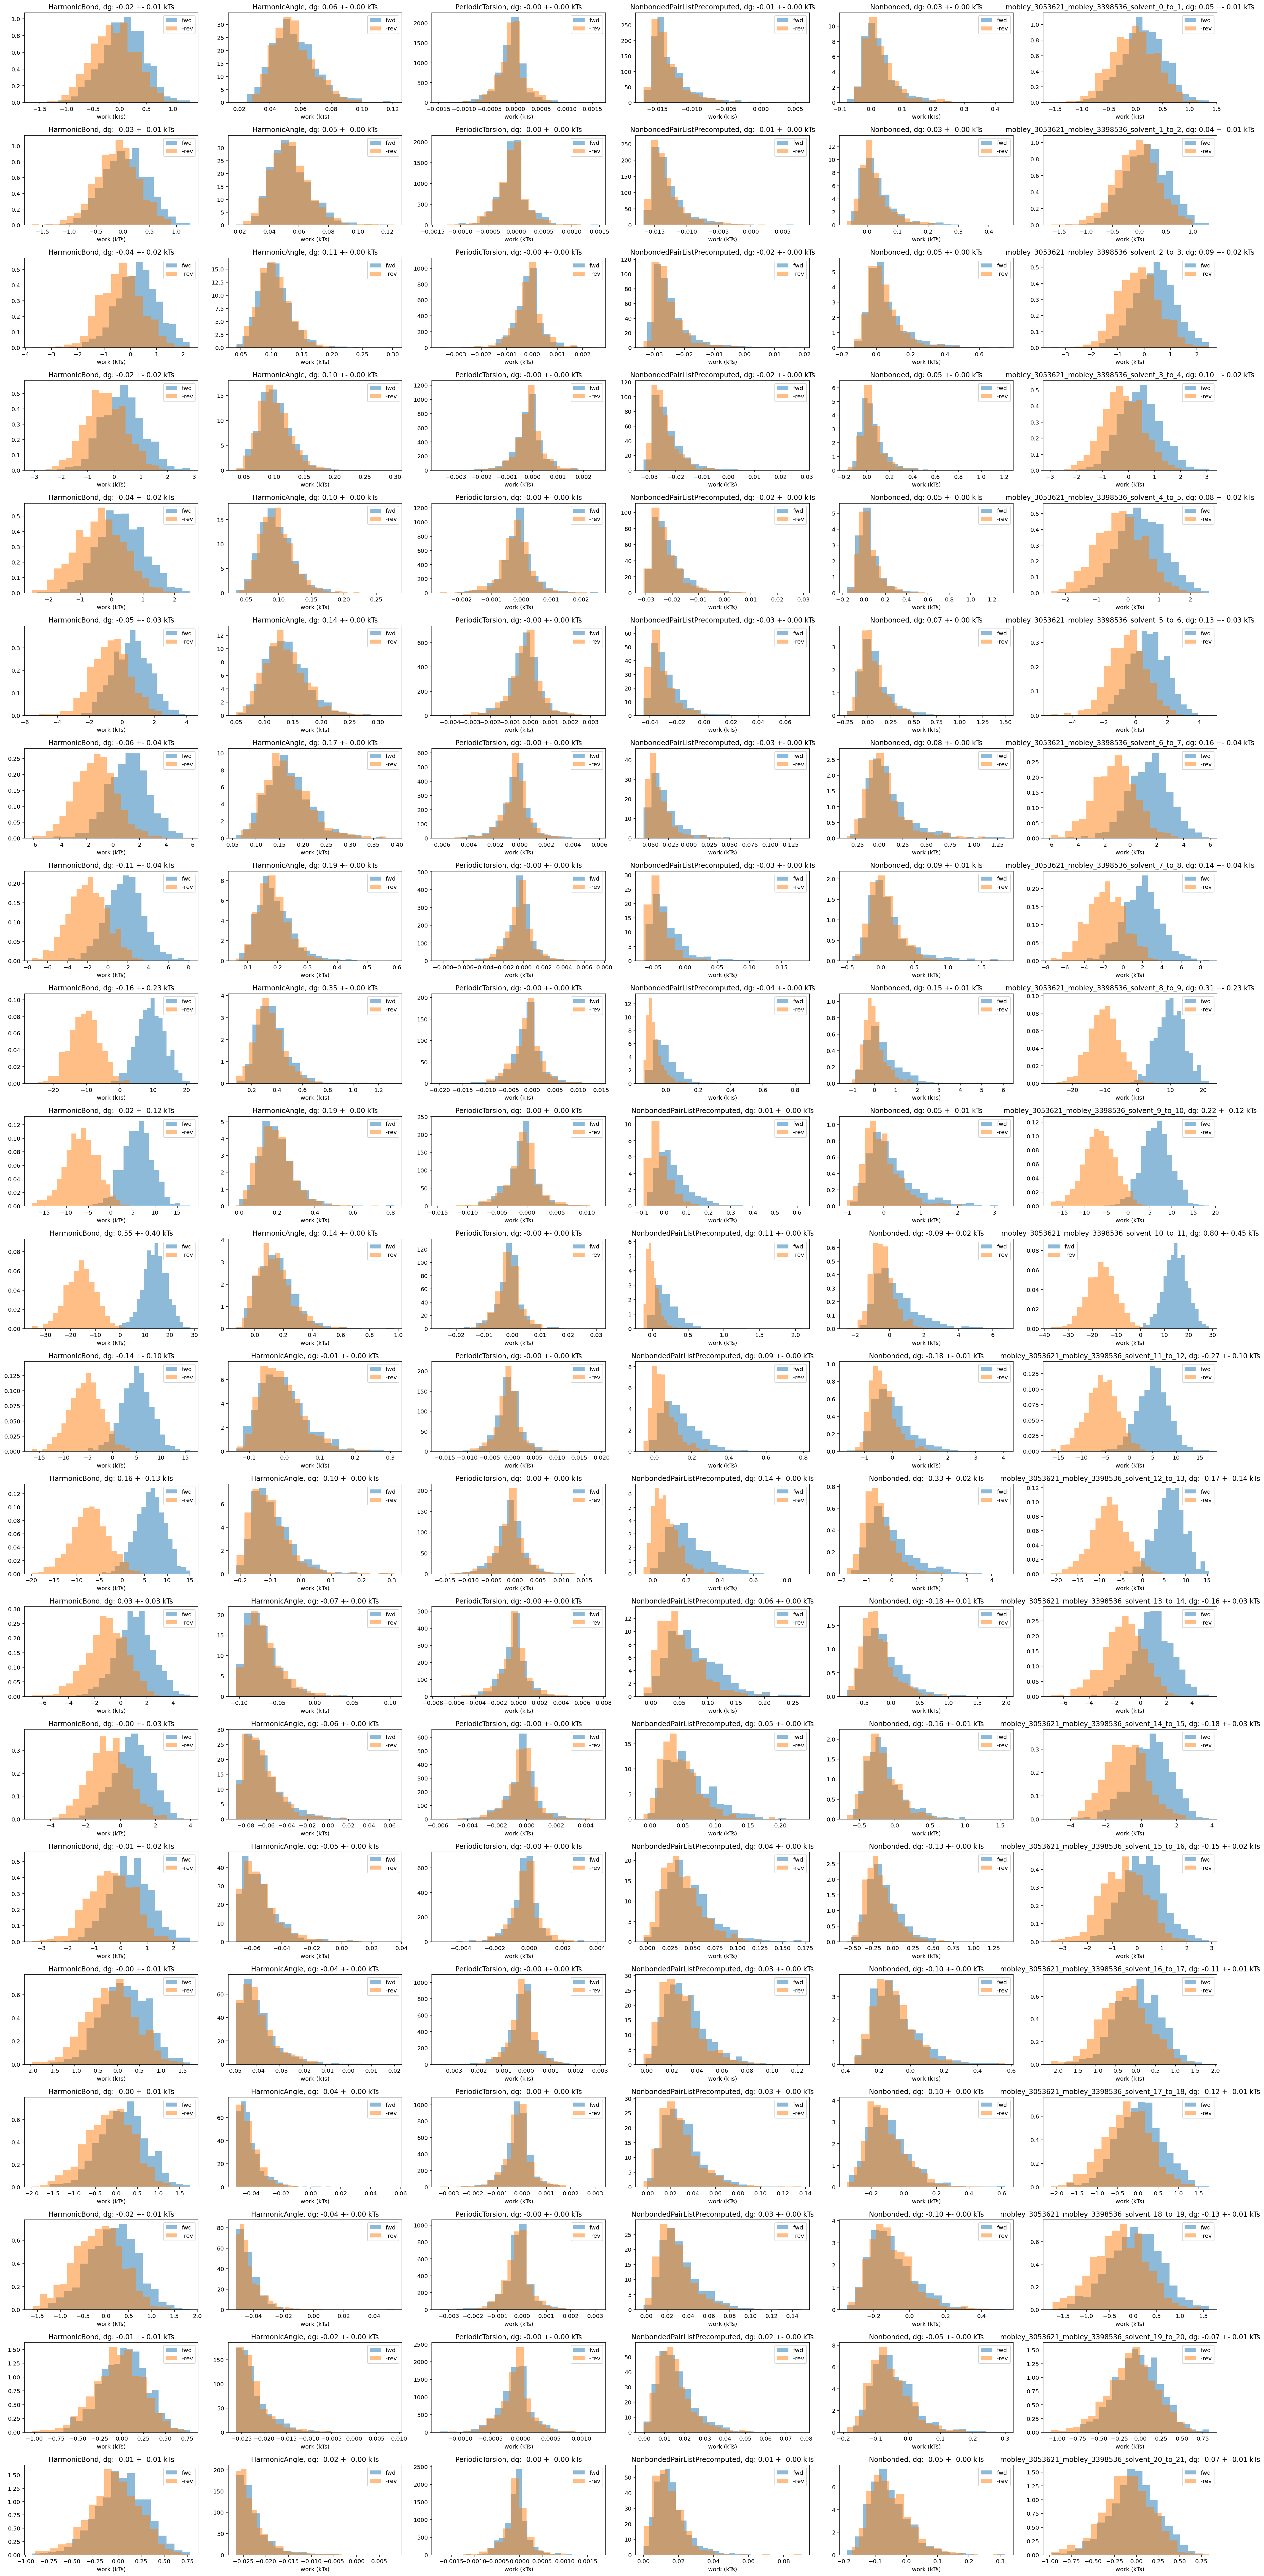

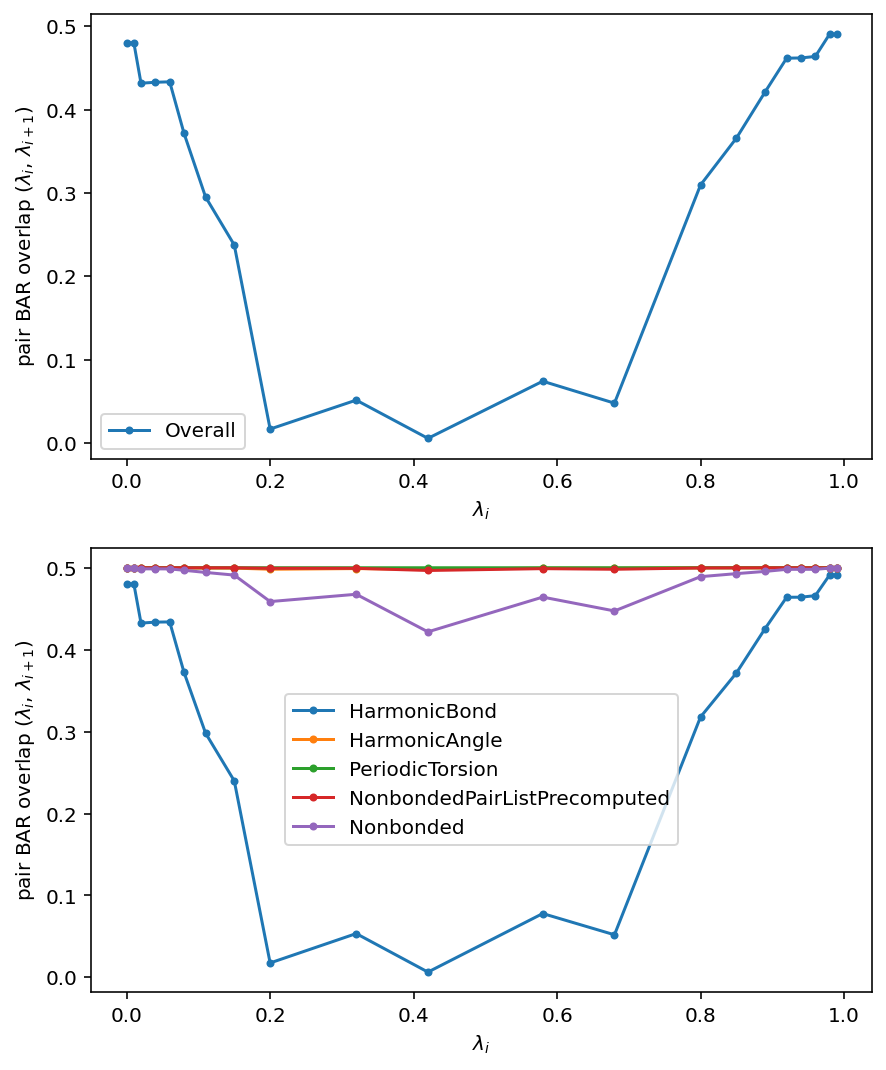

In [17]:
%%time
solvent_sys, solvent_conf, solvent_box, solvent_top = build_water_system(box_width=4.0)
solvent_box += np.diag([0.1, 0.1, 0.1])  # remove any possible clashes
solvent_host_config = HostConfig(solvent_sys, solvent_conf, solvent_box)

solvent_res = estimate_relative_free_energy(
    mol_a,
    mol_b,
    core,
    forcefield,
    solvent_host_config,
    seed=123,
    n_frames=1000,
    prefix="solvent",
    n_eq_steps=10000,
)

In [18]:
solvent_dG = np.array(solvent_res.all_dGs).sum() / KCAL_TO_KJ
solvent_dG_err = np.linalg.norm(solvent_res.all_errs) / KCAL_TO_KJ
solvent_dG, solvent_dG_err

(0.429417323661172, 0.3301721962617628)

## $\Delta \Delta G_{\text{hyd}}$

In [19]:
ddG = solvent_dG - vacuum_dG
ddG_err = np.linalg.norm([solvent_dG_err, vacuum_dG_err])
ddG, ddG_err

(1.2004517956826142, 0.46912321717590316)